In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/topgun6/top_gun_opendata_6.parquet
/kaggle/input/topgun1/top_gun_opendata_1.parquet
/kaggle/input/topgun4d/top_gun_opendata_4.parquet
/kaggle/input/topgun/top_gun_opendata_2.parquet


# Importing libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import train_test_split
import seaborn as sns

# Reading the data file

In [3]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq

chunk_size = 60

def get_dataset(data_dir):
    dfs = []
    for file_name in os.listdir(data_dir):
        parquet_file = pq.ParquetFile(f'{data_dir}/{file_name}')
        total_rows = parquet_file.metadata.num_rows

        for i in range(0, total_rows, chunk_size):
            chunk = parquet_file.read_row_group(i)
            df = chunk.to_pandas()
            dfs.append(df)

    dataset = pd.concat(dfs, ignore_index=True)
    return dataset

def to_3d(arr):
    return np.array([np.stack(np.stack(arr)[i], axis=-1) for i in range(8)])

# Prepartion of DATA

In [4]:
# Load dataset
DATA_DIR2 = "/kaggle/input/topgun"
DATA_DIR1 = "/kaggle/input/topgun1"
DATA_DIR4 = "/kaggle/input/topgun4d"
DATA_DIR6 = "/kaggle/input/topgun6"
df = get_dataset(DATA_DIR2)
df1 = get_dataset(DATA_DIR1)
df4 = get_dataset(DATA_DIR4)
df6 = get_dataset(DATA_DIR6)

dataset = pd.concat([df, df1,df4, df6], ignore_index=True)

# Check the shape of the combined dataset
print(dataset.shape)

# Display the first few rows
print(dataset.head())


# Apply the transformation efficiently
dataset['X_jet'] = dataset['X_jet'].apply(to_3d)

# Check shape of transformed data
print(dataset['X_jet'][0].shape)  # Should print (8, 125, 125)

(10020, 5)
                                               X_jet           m  iphi  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  286.703217   5.0   
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  123.929375  39.0   
2  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  326.478912  40.0   
3  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  381.457001  66.0   
4  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  389.105591  55.0   

           pt  ieta  
0  905.279175  18.0  
1  855.476379  18.0  
2  434.624542  26.0  
3  765.412109  13.0  
4  837.912048  37.0  
(8, 125, 125)


# Simple plot for a x_jet channel

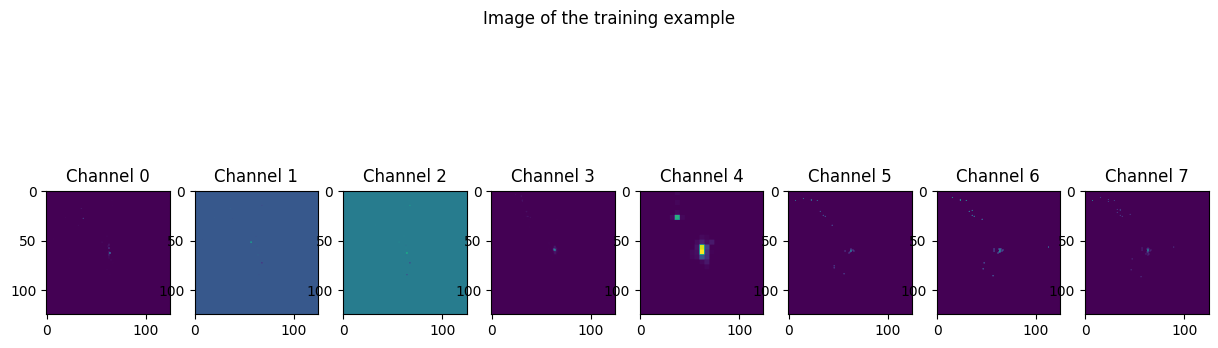

In [5]:
import matplotlib.pyplot as plt

# Plot the first 8 channels of the first training example
fig, axes = plt.subplots(1, 8, figsize=(15, 5))  # 1 row, 8 columns

for i in range(8):  # Assuming X_jets has at least 3 channels
    axes[i].imshow(dataset['X_jet'][9][i, :, :], cmap='viridis')  # Use cmap for better visualization
    axes[i].set_title(f"Channel {i}")

plt.suptitle("Image of the training example")
plt.show()

# Simple plot for x_jet one channel, multiple jets plots

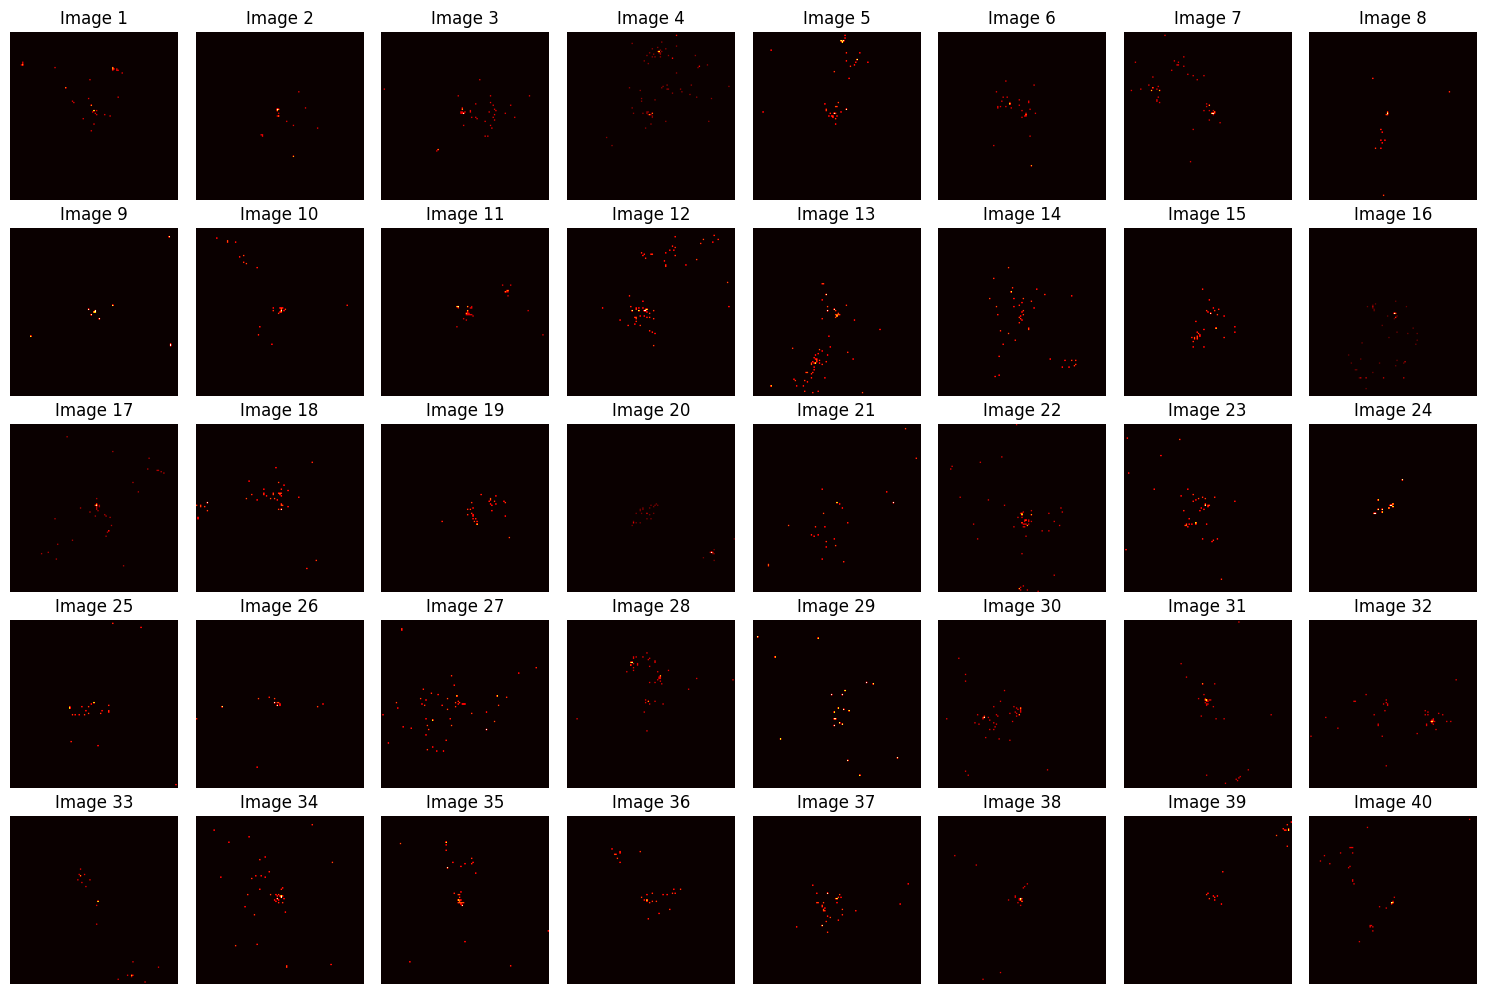

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(15, 10))  # 10x8 grid for 80 images

for i, ax in enumerate(axes.flatten()):
    if i >= len(dataset):  # Avoid index error if dataset has fewer than 80 samples
        ax.axis('off')  # Hide extra subplots
        continue

    image = dataset['X_jet'][i][6, :, :]  # Using channel 5 of each sample
    ax.imshow(image, cmap='hot')  # Better visualization
    ax.set_title(f'Image {i+1}')
    ax.axis('off')  # Remove axes for better display

plt.tight_layout()
plt.show()


# A function to plot channels and jets

In [7]:
def image_channel(n, channel):
    total_channels = 8

    # Validate channel number
    if channel < 0 or channel >= total_channels:
        raise ValueError(f"Invalid channel: {channel}. Must be between 0 and {total_channels - 1}.")

    cols = 8
    rows = n
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 8))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(dataset['X_jet']):
            break  # Don't access more images than exist

        # Extract the selected channel from the (8, 125, 125) array
        image = dataset['X_jet'][i][channel, :, :]

        ax.imshow(image, cmap='hot')
        ax.set_title(f"Image {i+1}")
        ax.axis("off")

        if i % cols == 0:  # First column of each row
            row_number = (i // cols) + 1
            ax.text(-0.5, 62, f"Jet {row_number}", va='center', ha='right', fontsize=8, weight='bold', rotation=90)


    plt.tight_layout()
    plt.show()

    return rows * cols
#channel index:0,1,2,3,4,5,6,7
#best channels for training:3,4,5,6,7

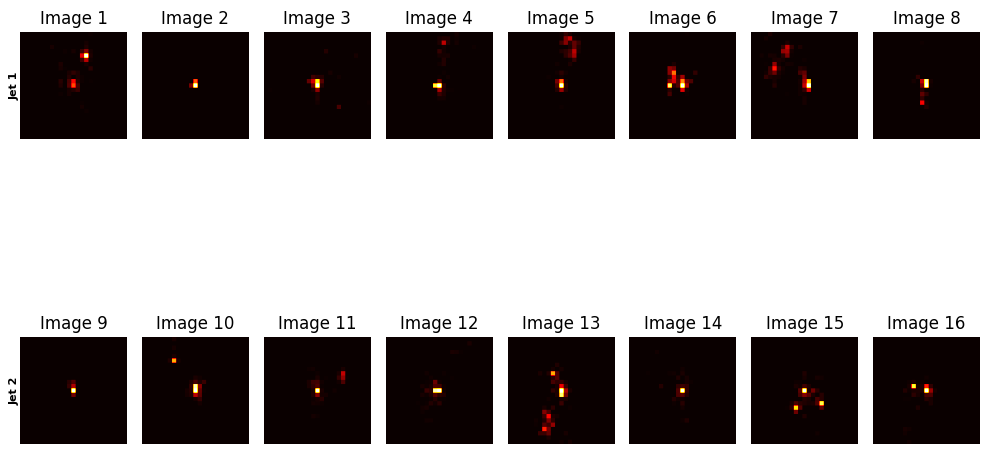

16

In [8]:
image_channel(2,4)

# preparing training data

In [9]:
X = dataset.drop(columns=['m'])
y = dataset['m']

In [10]:
X

,X_jet,iphi,pt,ieta
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",5.0,905.279175,18.0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",39.0,855.476379,18.0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",40.0,434.624542,26.0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",66.0,765.412109,13.0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",55.0,837.912048,37.0
...,...,...,...,...
10015,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",38.0,905.649658,40.0
10016,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",49.0,546.074280,23.0
10017,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",29.0,557.161194,33.0
10018,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",13.0,678.553040,40.0


# Feature coorelation check

In [11]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Prepare features and target
X = dataset[['pt', 'ieta', 'iphi']].values  # Select numerical features
y = dataset['m'].values  # Regression target

# Train a simple model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = rf.feature_importances_
feature_names = ['pt', 'ieta', 'iphi']

# Print feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.4f}")


Feature: pt, Importance: 0.5256
Feature: ieta, Importance: 0.1838
Feature: iphi, Importance: 0.2906


# all training data ready to launch

In [12]:
import numpy as np

x_train = []
y_train = []
pt_train = []

for i in range(len(dataset)):
    x_jet = dataset['X_jet'][i]
    selected_channels = x_jet[4:6]  # Selecting only channels 4 & 5
    x_train.append(selected_channels)

    y_train.append(dataset['m'][i])   # Mass values.

    pt_train.append(dataset['pt'][i]) # Transverse momentum

x_train = np.array(x_train)
y_train = np.array(y_train)
pt_train = np.array(pt_train)

In [13]:
#Before min max scaling
print(f"y_train looks like {y_train[0]}")
print(f"pt_train looks like {pt_train[0]}")
print(y_train.shape)
print(pt_train.shape)

y_train looks like 286.7032165527344
pt_train looks like 905.2791748046875
(10020,)
(10020,)


# saving mean for undo the scaling

In [14]:
y_untrained_min = y_train.min()
pt_untrained_min = pt_train.min()
y_untrained_max = y_train.max()
pt_untrained_max = pt_train.max()

print(f"y_untrained_min = {y_untrained_min}")
print(f"pt_untrained_min = {pt_untrained_min}")
print(f"y_untrained_max = {y_untrained_max}")
print(f"pt_untrained_max = {pt_untrained_max}")


y_untrained_min = 85.30828094482422
pt_untrained_min = 400.1187744140625
y_untrained_max = 499.99395751953125
pt_untrained_max = 999.9520874023438


# Scaling done

In [15]:

x_train = np.moveaxis(x_train, 1, -1)


x_mean = x_train.mean()
x_std = x_train.std()
x_train = (x_train - x_mean) / x_std  # Standardization (centered around 0)


def safe_minmax_scaling(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val + 1e-8)  # Adding small value to prevent div by zero

pt_train = safe_minmax_scaling(pt_train)
y_train = safe_minmax_scaling(y_train)


scaling_values = {
    "x_mean": x_mean, "x_std": x_std,
    "pt_min": np.min(pt_train), "pt_max": np.max(pt_train),
    "y_min": np.min(y_train), "y_max": np.max(y_train)
}

In [16]:
#After min max scaling
print(f"y_train looks like {y_train[0]}")
print(f"pt_train looks like {pt_train[0]}")

y_train looks like 0.48565684078256705
pt_train looks like 0.8421679647393516


In [17]:
# print(x_train.shape)
print(y_train.shape)
print(pt_train.shape)


(10020,)
(10020,)


# Train test and split

In [18]:
from sklearn.model_selection import train_test_split

# First split: 60% train, 40% temp (val + test)
x_train, temp_x_val, y_train, temp_y_val, pt_train, temp_pt_val = train_test_split(
    x_train, y_train, pt_train,
    test_size=0.4, 
    random_state=42
)

# Second split: 50% of temp set for validation, 50% for test (each 20% of total data)
x_val, x_test, y_val, y_test, pt_val, pt_test = train_test_split(
    temp_x_val, temp_y_val, temp_pt_val,
    test_size=0.5, 
    random_state=42
)

print(f"Train set: {x_train.shape}, {y_train.shape}")
print(f"Vay_untrained_meanlidation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")


Train set: (6012, 125, 125, 2), (6012,)
Vay_untrained_meanlidation set: (2004, 125, 125, 2), (2004,)
Test set: (2004, 125, 125, 2), (2004,)


In [19]:
print("Before tensor conversion:")
print("y_train min/max:", y_train.min(), y_train.max())
print("pt_train min/max:", pt_train.min(), pt_train.max())


Before tensor conversion:
y_train min/max: 0.00040979745234665654 0.9998272057910761
pt_train min/max: 0.0 0.9999999999833287


In [20]:
y_min = y_train.min()
y_max = y_train.max()
pt_min = pt_train.min()
pt_max = pt_train.max()

# reshaping pytorch way

In [21]:
# Convert to PyTorch tensors(need to change the order of X[n,32,32,2] to X[n,2,32,32])
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2)  # Validation tensor
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)  # Test tensor

pt_train_tensor = torch.tensor(pt_train, dtype = torch.float32)
pt_val_tensor  = torch.tensor(pt_val, dtype = torch.float32)
pt_test_tensor = torch.tensor(pt_test, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Training labels
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)  # Validation labels
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Test labels



In [22]:
print("\nAfter tensor conversion:")
print("y_train_tensor min/max:", y_train_tensor.min().item(), y_train_tensor.max().item())
print("pt_train_tensor min/max:", pt_train_tensor.min().item(), pt_train_tensor.max().item())



After tensor conversion:
y_train_tensor min/max: 0.000409797445172444 0.9998272061347961
pt_train_tensor min/max: 0.0 1.0


# loading data in a train loader

In [23]:
# Ensure pt tensors are (n, 1) instead of (n,)
pt_train_tensor = pt_train_tensor.unsqueeze(1)  # (n, 1)
pt_val_tensor = pt_val_tensor.unsqueeze(1)
pt_test_tensor = pt_test_tensor.unsqueeze(1)

# Create datasets with (x, pt, y)
train_dataset = data.TensorDataset(x_train_tensor, pt_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(x_val_tensor, pt_val_tensor, y_val_tensor)
test_dataset = data.TensorDataset(x_test_tensor, pt_test_tensor, y_test_tensor)

# DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
print("\nAfter tensor unsqeeze:")
print("y_train_tensor min/max:", y_train_tensor.min().item(), y_train_tensor.max().item())
print("pt_train_tensor min/max:", pt_train_tensor.min().item(), pt_train_tensor.max().item())



After tensor unsqeeze:
y_train_tensor min/max: 0.000409797445172444 0.9998272061347961
pt_train_tensor min/max: 0.0 1.0


In [25]:
print("pt_train_tensor shape:", pt_train_tensor.shape)
print("Sample pt_train_tensor values:", pt_train_tensor[:5])
print(y_train_tensor[0])
print(pt_train_tensor[0])

pt_train_tensor shape: torch.Size([6012, 1])
Sample pt_train_tensor values: tensor([[0.0641],
        [0.0634],
        [0.3077],
        [0.9800],
        [0.2709]])
tensor(0.5125)
tensor([0.0641])


In [26]:
#data loader check
# Check first batch of DataLoader
for x_batch, pt_batch, y_batch in train_loader:
    print("Batch y_train min/max:", y_batch.min().item(), y_batch.max().item())
    print("Batch pt_train min/max:", pt_batch.min().item(), pt_batch.max().item())
    break  # Only check the first batch


Batch y_train min/max: 0.0046267518773674965 0.9825450778007507
Batch pt_train min/max: 0.06336324661970139 0.9954186677932739


In [27]:
print(pt_train_tensor[0])
print(pt_train[0])

tensor([0.0641])
0.06405827261678275


In [28]:
y_mins, y_maxs, pt_mins, pt_maxs = [], [], [], []

for x_batch, pt_batch, y_batch in train_loader:
    y_mins.append(y_batch.min().item())
    y_maxs.append(y_batch.max().item())
    pt_mins.append(pt_batch.min().item())
    pt_maxs.append(pt_batch.max().item())

print("Min y_train across batches:", min(y_mins))
print("Max y_train across batches:", max(y_maxs))
print("Min pt_train across batches:", min(pt_mins))
print("Max pt_train across batches:", max(pt_maxs))


Min y_train across batches: 0.000409797445172444
Max y_train across batches: 0.9998272061347961
Min pt_train across batches: 0.0
Max pt_train across batches: 1.0


# MODEL

In [29]:
#new onw

class SimpleCNNRegression(nn.Module):
    def __init__(self, input_channels=2):
        super(SimpleCNNRegression, self).__init__()

        # CNN Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            #nn.MaxPool2d(2, 2),  # Reduce spatial size
            
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(0.1),
            nn.Dropout(0.2),
            nn.AvgPool2d(2, 2),  # Reduce spatial size

            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            #nn.MaxPool2d(2, 2),  # Reduce spatial size

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape (batch_size, 16, 1, 1)
        )

        # Fully connected layer for CNN features
        self.fc_cnn = nn.Sequential(
            nn.Linear(32, 64),  # Increased size for better feature extraction
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1)
        )

        # Fully connected for pt feature
        self.fc_pt = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1)
        )

        # Final combined layer
        self.fc_combined = nn.Sequential(
            nn.Linear(256, 256),  # Corrected input size from 256+128 = 384
            nn.LayerNorm(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3, inplace=False),
            nn.Linear(256, 1),
            nn.LeakyReLU(0.15)
            #nn.Softplus()
            
        )

    def forward(self, x, pt):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)  # Flatten (batch_size, 16)

        x = self.fc_cnn(x)
        pt = self.fc_pt(pt)

        combined = torch.cat((x, pt), dim=1)
        #combined += torch.tanh(self.fc_combined(combined))

        output = self.fc_combined(combined)
        return output


In [30]:
import torch
import torch.nn as nn

class LogCoshLoss(nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()

    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true + 1e-12)))  


In [31]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = SimpleCNNRegression().to(device)

# Loss Function
criterion = LogCoshLoss()  # nn.SmoothL1Loss(beta=1.0) or nn.MSELoss()

# Optimizer with L2 regularization (weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5, weight_decay=5e-3)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.2)

# Early Stopping Parameters
early_stopping_patience = 5  # Stop if no improvement for 'patience' epochs
best_val_loss = float("inf")  # Track the best validation loss
epochs_no_improve = 0  # Counter for early stopping

num_epochs = 40  # Total training epochs

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    total_samples = 0  # Track total processed samples

    for batch_idx, (x, pt, y) in enumerate(train_loader):
        x, pt, y = x.to(device), pt.to(device), y.to(device).view(-1, 1)

        optimizer.zero_grad()
        output = model(x, pt)

        loss = criterion(output, y)
        loss.backward()

        # Apply gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        batch_size = x.size(0)  # Get batch size
        running_loss += loss.item() * batch_size  # Multiply loss by batch size
        total_samples += batch_size  # Accumulate processed samples

    epoch_train_loss = running_loss / total_samples  # Compute proper mean loss
    train_losses.append(epoch_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for batch_idx, (x, pt, y) in enumerate(val_loader):
            x, pt, y = x.to(device), pt.to(device), y.to(device).view(-1, 1)

            output = model(x, pt)
            loss = criterion(output, y)

            batch_size = x.size(0)
            val_loss += loss.item() * batch_size  # Multiply by batch size
            total_val_samples += batch_size

    epoch_val_loss = val_loss / total_val_samples  # Compute mean loss
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

    # Learning rate adjustment
    scheduler.step(epoch_val_loss)

    # Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break  # Stop training

print("Training complete!")


Epoch 1/30 | Train Loss: 0.059451 | Val Loss: 0.041127
Epoch 2/30 | Train Loss: 0.049086 | Val Loss: 0.040844
Epoch 3/30 | Train Loss: 0.044658 | Val Loss: 0.039685
Epoch 4/30 | Train Loss: 0.042892 | Val Loss: 0.039234
Epoch 5/30 | Train Loss: 0.042118 | Val Loss: 0.039191
Epoch 6/30 | Train Loss: 0.040791 | Val Loss: 0.039767
Epoch 7/30 | Train Loss: 0.040401 | Val Loss: 0.039189
Epoch 8/30 | Train Loss: 0.039594 | Val Loss: 0.040579
Epoch 9/30 | Train Loss: 0.038901 | Val Loss: 0.036704
Epoch 10/30 | Train Loss: 0.038446 | Val Loss: 0.036554
Epoch 11/30 | Train Loss: 0.038606 | Val Loss: 0.036421
Epoch 12/30 | Train Loss: 0.038331 | Val Loss: 0.036325
Epoch 13/30 | Train Loss: 0.038171 | Val Loss: 0.036142
Epoch 14/30 | Train Loss: 0.038281 | Val Loss: 0.036094
Epoch 15/30 | Train Loss: 0.037935 | Val Loss: 0.035914
Epoch 16/30 | Train Loss: 0.037830 | Val Loss: 0.035834
Epoch 17/30 | Train Loss: 0.037751 | Val Loss: 0.035800
Epoch 18/30 | Train Loss: 0.037440 | Val Loss: 0.035679
E

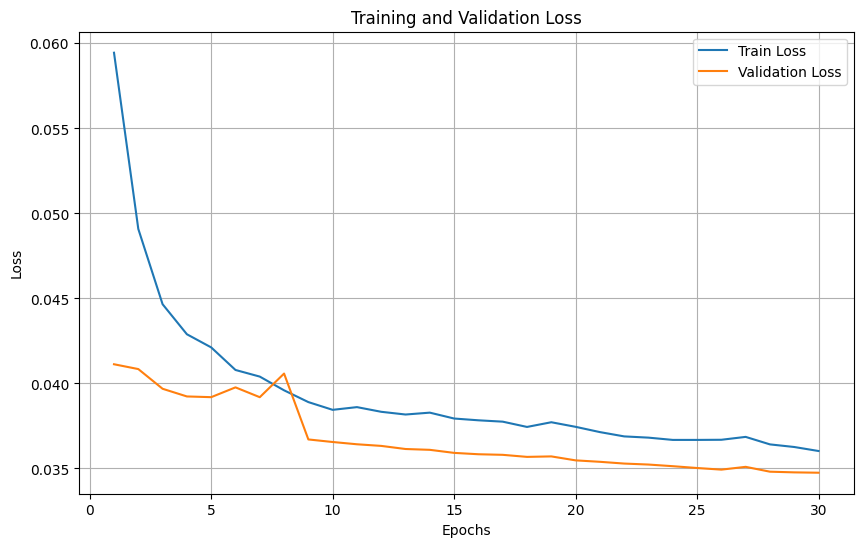

In [32]:
epochs_completed = len(train_losses)  # Use the actual number of recorded epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_completed + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Ensure model is in evaluation mode
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for x, pt, y in test_loader:  # Use a test dataset
        x, pt, y = x.to(device), pt.to(device), y.to(device).view(-1, 1)

        output = model(x, pt)  # Get model prediction
        predictions.append(output.cpu().numpy())  # Collect predictions
        actuals.append(y.cpu().numpy())  # Collect actual values

# Convert lists to numpy arrays
predictions = np.vstack(predictions)  # More robust than np.concatenate
actuals = np.vstack(actuals)  

# Reverse scaling (if Min-Max Scaling was used)
y_min_test = y_untrained_min.item() if isinstance(y_untrained_min, torch.Tensor) else float(y_untrained_min)
y_max_test = y_untrained_max.item() if isinstance(y_untrained_max, torch.Tensor) else float(y_untrained_max)

# Apply inverse transformation
predictions_original = np.clip(predictions * (y_max_test - y_min_test) + y_min_test, y_min_test, y_max_test)
actuals_original = np.clip(actuals * (y_max_test - y_min_test) + y_min_test, y_min_test, y_max_test)

# Calculate error
error = predictions_original - actuals_original

# Print some sample results
print("\nSample Predictions:")
for i in range(min(50, len(actuals_original))):  # Avoids index error
    print(f"Actual: {actuals_original[i][0]:.4f}, Predicted: {predictions_original[i][0]:.4f}, Error: {error[i][0]:.4f}")



Sample Predictions:
Actual: 163.4662, Predicted: 269.6282, Error: 106.1620
Actual: 406.6667, Predicted: 380.6882, Error: -25.9785
Actual: 258.2383, Predicted: 280.9698, Error: 22.7314
Actual: 315.8697, Predicted: 279.9008, Error: -35.9689
Actual: 470.3771, Predicted: 392.1654, Error: -78.2117
Actual: 127.8327, Predicted: 276.1917, Error: 148.3590
Actual: 144.1477, Predicted: 247.4973, Error: 103.3497
Actual: 95.6160, Predicted: 212.9197, Error: 117.3036
Actual: 495.2391, Predicted: 313.6047, Error: -181.6344
Actual: 499.2672, Predicted: 415.9670, Error: -83.3003
Actual: 147.4018, Predicted: 246.9427, Error: 99.5409
Actual: 207.7563, Predicted: 313.5061, Error: 105.7498
Actual: 392.9360, Predicted: 325.0992, Error: -67.8368
Actual: 363.2499, Predicted: 353.0379, Error: -10.2120
Actual: 182.2641, Predicted: 378.8915, Error: 196.6275
Actual: 418.2226, Predicted: 291.1102, Error: -127.1124
Actual: 116.2287, Predicted: 292.0337, Error: 175.8050
Actual: 306.6018, Predicted: 319.4466, Error:

In [34]:
# Calculate Mean Absolute Error (MAE) for quick evaluation
mae = np.mean(np.abs(predictions_original - actuals_original))
print(f"\nMean Absolute Error (MAE): {mae:.4f}")



Mean Absolute Error (MAE): 92.9196


In [35]:
actuals_original[0]


array([163.4662], dtype=float32)

In [36]:
predictions_original[0]

array([269.62823], dtype=float32)

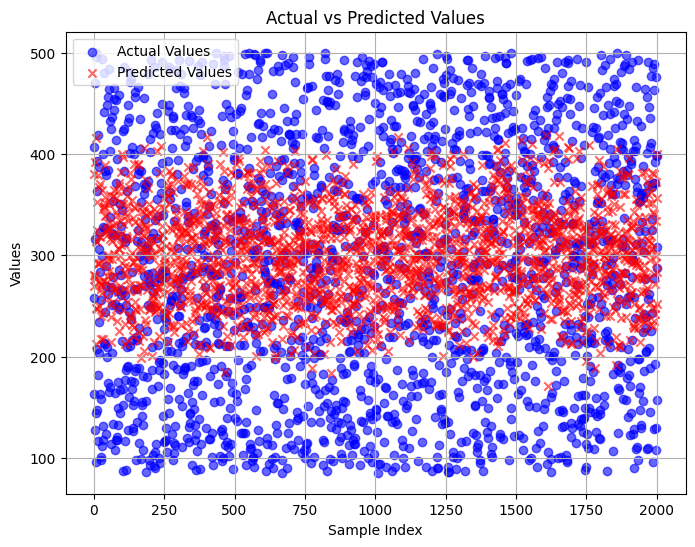

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot for Actual values
plt.scatter(range(len(actuals_original)), actuals_original, color='blue', marker='o', label='Actual Values', alpha=0.6)

# Scatter plot for Predicted values
plt.scatter(range(len(predictions_original)), predictions_original, color='red', marker='x', label='Predicted Values', alpha=0.6)



# Labels and title
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [38]:
import numpy as np
error = np.array(error)  # Convert to NumPy array if not already
error = error.flatten()


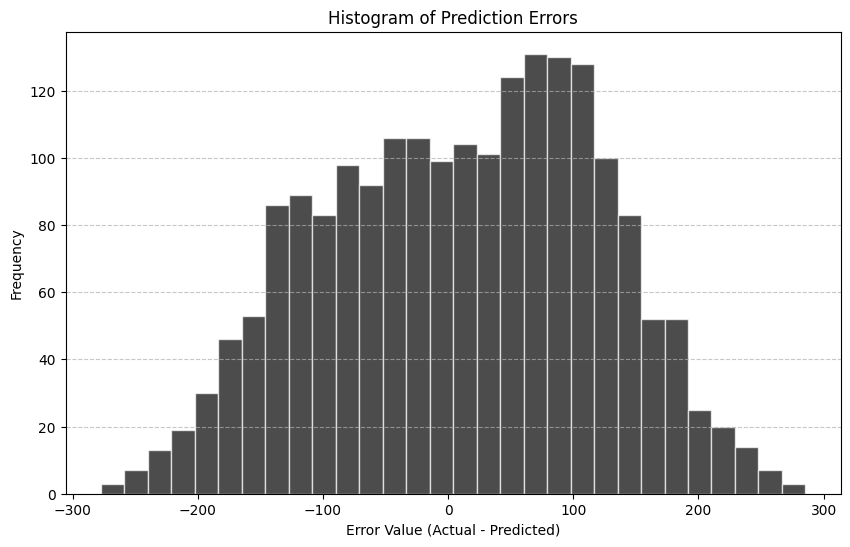

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(error, bins=30, color='black', alpha=0.7, edgecolor='white')

# Labels and title
plt.xlabel("Error Value (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid on y-axis

# Show plot
plt.show()


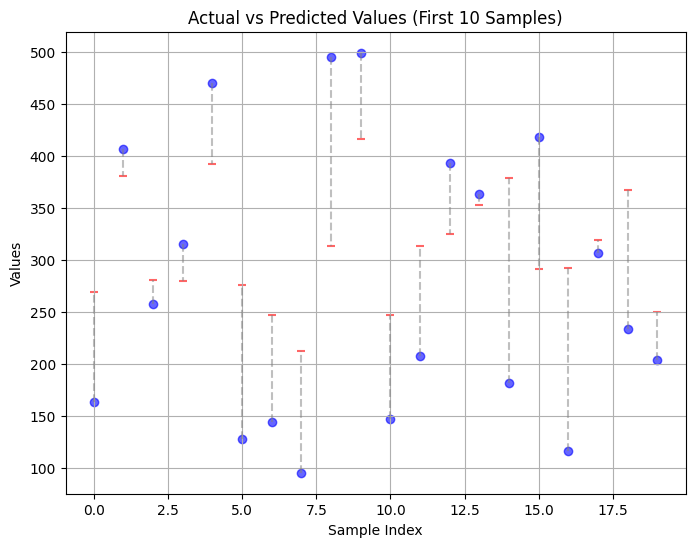

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Take the first 10 values
indices = np.arange(20)
actuals_10 = actuals_original[:20]
predictions_10 = predictions_original[:20]

plt.figure(figsize=(8, 6))

# Scatter plot for Actual values
plt.scatter(indices, actuals_10, color='blue', marker='o', label='Actual Values', alpha=0.6)

# Scatter plot for Predicted values
plt.scatter(indices, predictions_10, color='red', marker='_', label='Predicted Values', alpha=0.6)

# Connect actual and predicted values with a line
for i in range(20):
    plt.plot([indices[i], indices[i]], [actuals_10[i], predictions_10[i]], color='gray', linestyle='--', alpha=0.5)

# Labels and title
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values (First 10 Samples)")
#plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [42]:
model_path = "/kaggle/working/model.pth" 
torch.save(model.state_dict(), model_path)
print("Model saved at:", model_path)

Model saved at: /kaggle/working/model.pth
